In [1]:
import scipy.integrate
import scipy.sparse
import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
from pandas import DataFrame

class IVPResult:
    pass

def solve_ivp(f, ts, x0, p=None, integrator='dopri5', store_trajectory=False,
              sens=False, dfx=None, dfp=None):
    """
    Solve initial value problem
        d/dt x = f(t, x, p);  x(t0) = x0.

    Evaluate Solution at time points specified in ts, with ts[0] = t0.

    Compute sensitivity matrices evaluated at time points in ts if sens=True.
    """

    if sens:
        def f_vode(t, xGxGp, p):
            x     = xGxGp[:x0.shape[0]]
            Gx    = xGxGp[x0.shape[0]:x0.shape[0]+x0.shape[0]*x0.shape[0]]
            Gx    = Gx.reshape([x0.shape[0], x0.shape[0]])
            Gp    = xGxGp[x0.shape[0]+x0.shape[0]*x0.shape[0]:]
            Gp    = Gp.reshape([x0.shape[0], p.shape[0]])
            dx    = f(t, x, p)
            dfxev = dfx(t, x, p)
            dfpev = dfp(t, x, p)
            dGx   = dfxev.dot(Gx)
            dGp   = dfxev.dot(Gp) + dfpev
            return np.concatenate(
                [dx,
                 dGx.reshape(-1),
                 dGp.reshape(-1)])

        ivp = scipy.integrate.ode(f_vode)
    else:
        ivp = scipy.integrate.ode(f)

    ivp.set_integrator(integrator)

    if store_trajectory:
        times = []
        points = []
        def solout(t, x):
            if len(times) == 0 or t != times[-1]:
                times.append(t)
                points.append(np.copy(x[:x0.shape[0]]))
        ivp.set_solout(solout)

    if sens:
        ivp.set_initial_value(np.concatenate(
            [x0,
             np.eye(x0.shape[0]).reshape(-1),
             np.zeros([x0.shape[0], p.shape[0]]).reshape(-1)
            ]), ts[0])
    else:
        ivp.set_initial_value(x0, ts[0])
    ivp.set_f_params(p)

    result = IVPResult()
    result.ts = ts
    result.xs  = np.zeros([ts.shape[0], x0.shape[0]])
    if sens:
        result.Gxs = np.zeros([ts.shape[0], x0.shape[0], x0.shape[0]])
        result.Gps = np.zeros([ts.shape[0], x0.shape[0], p.shape[0]])
    result.success = True

    result.xs[0,:] = x0
    
    #meine Vermutung:
    if sens:
        result.Gxs[0,:,:] = np.eye(x0.shape[0])
        
    for ii in range(1,ts.shape[0]):
        ivp.integrate(ts[ii])
        result.xs[ii,:]    = ivp.y[:x0.shape[0]]
        if sens:
            result.Gxs[ii,:,:] = ivp.y[x0.shape[0]:x0.shape[0]+x0.shape[0]*x0.shape[0]].reshape([x0.shape[0], x0.shape[0]])
            result.Gps[ii,:,:] = ivp.y[x0.shape[0]+x0.shape[0]*x0.shape[0]:].reshape([x0.shape[0], p.shape[0]])
        if not ivp.successful():
            result.success = False
            break

    if store_trajectory:
        result.trajectory_t = np.array(times)
        result.trajectory_x = np.array(points)

    return result

def condensing(cache, m, n):
    E = cache['D_' + str(m)]
    P = cache['D_p']
    u = cache['F_1']

    for l in range(m, 0, -1):
        l_1 = str(l - 1)
        u = u + E.dot(cache['h_' + l_1])
        P = P + E.dot(cache['Gp_' + l_1])
        #print(P)
        E = cache['D_' + l_1] + E.dot(cache['G_' + l_1])
    Dx0 = np.linalg.lstsq(np.hstack((E, P)), -u)[0]
    Ds = np.zeros((m + 1) * n)
    Ds[:n] = Dx0[:n]
    Dp = Dx0[n:]
    for l in range(m):
        l_ = str(l)
        temp = cache['h_' + l_] + cache['G_' + l_].dot(Ds[n * l: n * (l + 1)])
        Ds[n * (l + 1): n * (l + 2)] = temp + cache['Gp_' + l_].dot(Dp)
    return Ds, Dp


In [2]:
def dX_dt(t, X, p): #predator-prey DEs
    R = X[0]
    F = X[1]
    alpha, beta, gamma, delta = p
    dRdt = alpha * R - beta * F * R
    dFdt = gamma * R * F - delta * F
    return np.array([dRdt,dFdt])

def dfx(t, X, p):

    R = X[0]
    F = X[1]
    alpha, beta, gamma, delta = p
    return np.array([alpha - beta * F, - beta * R, gamma * F,\
                            gamma * R -  delta]).reshape((2, 2))

def dfp(t, X, p):
    R = X[0]
    F = X[1]
    alpha, beta, gamma, delta = p

    return np.array([[R, - F * R, 0., 0.],[0., 0.,  R * F, -F]])

In [3]:
# delta x should be a vector of dimension equal to the number
# of variables, which is true only if we do not change the parameters.
def evaluate_multiple_shooting(f, dfx, dfp, meas_times, meas_values, s_guesses, p):
    cache = {}
    m, nx = s_guesses.shape
    for i in range(m-1):
        meas_times_interval = meas_times[i:i+2]
        s0 = deepcopy(s_guesses[i])
        temp_result = solve_ivp(f, meas_times_interval, s0, p=p, sens=True, dfx=dfx, dfp=dfp)
        cache['h_' + str(i)] = (temp_result.xs[1] - s_guesses[i + 1])
        cache['G_' + str(i)] = temp_result.Gxs[1]
        cache['Gp_' + str(i)] = temp_result.Gps[1]
    for l in range(m):
        cache['D_' + str(l)] = -np.eye(m * nx, nx, -nx * l)
    cache['D_p'] = np.zeros((m*nx, len(p)))
    cache['F_1'] = (meas_values - s_guesses).flatten()
    return cache

In [4]:
def gauss_newton(F_J, s_guesses, param, meas_times, meas_values, itmax=100, tol=1e-7, verbose=1):
    m, nx = s_guesses.shape
    tau = 1.
    if verbose == 1:
        print("Start gauss_newton with itmax=",itmax,"and tol=",tol,"and tau=",tau)
        Fs = np.zeros(itmax+1)
    i = 0
    norm = tol+1.0
    dx_prev = 1
    while i<itmax and norm > tol:
        cache = F_J(dX_dt, dfx, dfp, meas_times, meas_values, s_guesses, param)
        Ds, Dp = condensing(cache, m - 1, nx)

        param += tau * Dp
        s_increase = Ds.reshape((m, nx))
        norm = np.linalg.norm(Ds)
        
        s_guesses += tau * s_increase
        i += 1
        print('Iteration:', i)
        print('|F1|', np.linalg.norm(cache['F_1']))
        #print('|F2|', np.linalg.norm(F2))
        print('|Dx|', np.linalg.norm(Ds))
        print('|k|', np.linalg.norm(Ds) / np.linalg.norm(dx_prev))
        dx_prev = deepcopy(Ds)
        #print(s_guesses)
        
        '''
        print('Dx')
        print(Dx)
        print('s_incr')
        print(s_increase)
        print('s_guess')
        print(s_guesses)
        print('dp')
        print(Dx[-len(param):])
        print(param)
        '''
        
        
    return s_guesses, param

In [5]:
np.random.seed(31)
meas_times = np.arange(21) * 5
noise = 5. * np.random.rand(21, 2)
s0_init = np.array([20., 10.])
param_init = np.array((.2, .01, .001, .1))
result = solve_ivp(dX_dt, meas_times, s0_init, p=param_init) #just to create the measurements
meas_values = result.xs + noise


print("Initial values close to the correct parameters:")
# We start with an alpha variation ftom the true values 
alpha = .01
s_guesses = deepcopy(meas_values)
#as given in the exercise we use the measurements at the grid points as guesses for the initial values
param = param_init * (1 + alpha * np.random.rand(len(param_init.shape))) 

s0, param = gauss_newton(evaluate_multiple_shooting, s_guesses,np.zeros(4),meas_times,meas_values)
'''
print('relative  error')
print((param - param_init) / param_init)
print((s0 - s0_init)/ s0_init, '\n')
print('estimated parameter vs true ones')
print(param)
print(param_init)
'''


Initial values close to the correct parameters:
Start gauss_newton with itmax= 100 and tol= 1e-07 and tau= 1.0
Iteration: 1
|F1| 0.0
|Dx| 198.953331788
|k| 198.953331788
Iteration: 2
|F1| 198.953331788
|Dx| 190.045141032
|k| 0.95522472192
Iteration: 3
|F1| 51.6001800534
|Dx| 54.9161518565
|k| 0.288963724925
Iteration: 4
|F1| 14.1712860752
|Dx| 5.17698292545
|k| 0.094270679034
Iteration: 5
|F1| 11.9155169106
|Dx| 0.442795003753
|k| 0.0855314784943
Iteration: 6
|F1| 11.985227044
|Dx| 0.00678202384183
|k| 0.0153163964912
Iteration: 7
|F1| 11.9852525949
|Dx| 0.000246266770962
|k| 0.0363116934864
Iteration: 8
|F1| 11.9852525866
|Dx| 1.25515539148e-05
|k| 0.0509673061687
Iteration: 9
|F1| 11.9852525865
|Dx| 6.95545709911e-07
|k| 0.0554151075342
Iteration: 10
|F1| 11.9852525865
|Dx| 3.96642679532e-08
|k| 0.0570261125732


"\nprint('relative  error')\nprint((param - param_init) / param_init)\nprint((s0 - s0_init)/ s0_init, '\n')\nprint('estimated parameter vs true ones')\nprint(param)\nprint(param_init)\n"

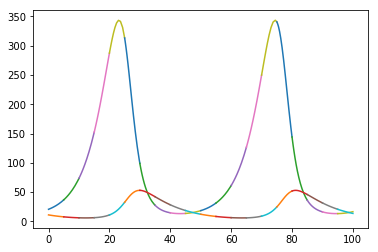

In [6]:
for l in range(20):
    x0 = s0[l]
    ts = np.array([meas_times[l], meas_times[l+1]])
    result = solve_ivp(dX_dt, ts, x0, p=param, integrator='dopri5', store_trajectory=True,
                       sens=True, dfx=dfx, dfp=dfp)
    plt.plot(result.trajectory_t, result.trajectory_x)